# Project 3

## Task 3

This task is to explore transfer learning by following the [official pytorch transfer learning tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html).

As with the previous tutorial, I did a lot of copy and pasting so I will give explanations for the functions as I go along to show that I actually understand what is happening.

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.optim import lr_scheduler
from torchvision import datasets, models
from torchvision.utils import make_grid
from pathlib import Path

from task2_functions import test
from task3_functions import data_transforms, view_grid, train_model, visualize_model


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


This next block creates Dataloaders and records some metadata about the data (size and class names). The Dataloaders are applying transforms to the input dataset ('hymenoptera'). Both the 'train' and 'val' transforms are doing some normalization, but the 'train' transform is also taking a random, resized crops of each input image and randomly flipping images (data augmentation).

In [2]:
data_dir = Path('data/hymenoptera')
image_datasets = {x: datasets.ImageFolder(data_dir / x,
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
print(image_datasets)

{'train': Dataset ImageFolder
    Number of datapoints: 244
    Root location: data\hymenoptera\train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           ), 'val': Dataset ImageFolder
    Number of datapoints: 153
    Root location: data\hymenoptera\val
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )}


In the next block, I am grabbing a single batch of data from the 'train' Dataloader and using a function I am calling `view_grid` along with the pytorch function `make_grid` to look at the data and some class labels. `view_grid` code is copied from the tutorial, but I changed the name of the function (originally `imshow`) to not be confused with `plt.imshow`.

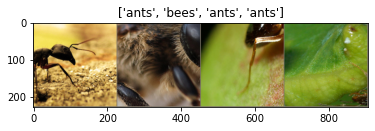

In [3]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = make_grid(inputs)

view_grid(out, title=[class_names[x] for x in classes])

This next bit starts to show how the transfer learning is taking place. First, I am loading a pretrained ResNet and taking a peak at `fc`, which is the final fully connected layer:

In [4]:
model_ft = models.resnet18(pretrained=True)
model_ft.fc

Linear(in_features=512, out_features=1000, bias=True)

This fully connected layer takes 512 features in and outputs 1000 features. We only need two features to account for ants and bees, so we make a new `fc`:

In [5]:
model_ft.fc = nn.Linear(512, 2)
model_ft = model_ft.to(device)

I am again using cross entropy for the loss function and stochastic gradient descent for optimization. Except this time I will also use a scheduler to adjust the learning rate as training progresses:

In [6]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

The training function is largely copied from the tutorial. It differs from the training function from the FashionMNIST tutorial in several respects. First, it is combining training and testing phases for each epoch in one function, and it has a parameter for specifying the number of epochs. This is convenient. It also is using a scheduler to adjust the learning rate. Interestingly, it is also freezing a copy of the running best model weights as training progresses. This would be helpful if model performance starts to degrade as training progresses (e.g., from overtraining).

For this run, I are training the entire ResNet, but starting from pretrainied weights for all but the fully connected layer. This runs pretty quickly for me, since I am using a powerful GPU.

In [7]:
model_ft = train_model(device, dataloaders, dataset_sizes, model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6391 Acc: 0.6557
val Loss: 0.2048 Acc: 0.9412

Epoch 1/24
----------
train Loss: 0.6392 Acc: 0.7336
val Loss: 0.2458 Acc: 0.9150

Epoch 2/24
----------
train Loss: 0.4110 Acc: 0.8238
val Loss: 0.2756 Acc: 0.9150

Epoch 3/24
----------
train Loss: 0.5302 Acc: 0.7746
val Loss: 0.2753 Acc: 0.9020

Epoch 4/24
----------
train Loss: 0.2438 Acc: 0.8975
val Loss: 0.4626 Acc: 0.8758

Epoch 5/24
----------
train Loss: 0.5710 Acc: 0.7828
val Loss: 0.5906 Acc: 0.8235

Epoch 6/24
----------
train Loss: 0.5470 Acc: 0.7910
val Loss: 0.3204 Acc: 0.9020

Epoch 7/24
----------
train Loss: 0.3651 Acc: 0.8320
val Loss: 0.2342 Acc: 0.9150

Epoch 8/24
----------
train Loss: 0.3565 Acc: 0.8402
val Loss: 0.2433 Acc: 0.9150

Epoch 9/24
----------
train Loss: 0.2491 Acc: 0.9016
val Loss: 0.2497 Acc: 0.9150

Epoch 10/24
----------
train Loss: 0.3861 Acc: 0.8197
val Loss: 0.2307 Acc: 0.9020

Epoch 11/24
----------
train Loss: 0.3340 Acc: 0.8566
val Loss: 0.2612 Acc: 0.9085

Ep

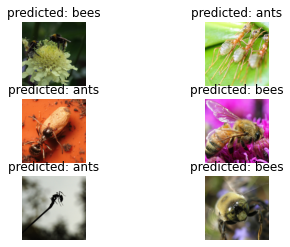

In [8]:
visualize_model(device, dataloaders, class_names, model_ft)

In [9]:
torch.save(model_ft, 'models/tfrln')

My best model gave me ~95% accuracy on the test data:

In [11]:
model_best = torch.load('models/tfrln_best')
test(device, dataloaders['val'], model_best, criterion)

Test Error: 
 Accuracy: 94.8%, Avg loss: 0.208973 

